# Lecture : Graph Clustering

## Lab 03 : Metis -- Exercise

### Xavier Bresson, Jiaming Wang


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/03_Graph_Clustering'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pip install pymetis==2023.1 # install metis 
    !pip install dgl==2.0.0 -f https://data.dgl.ai/wheels/repo.html # install dgl
    !pwd
    

In [ ]:
# Data conversion used in this notebook
#  from DGL to networkx :                          G_nx = dgl.to_networkx(G_dgl)
#  from scipy.sparse._csc.csc_matrix to DGL :      G_dgl = dgl.from_scipy(G_sp)
#  from scipy.sparse._csc.csc_matrix to networkx : G_nx = nx.from_scipy_sparse_array(G_sp)
#  from networkx to numpy :                        G_np = nx.to_numpy_array(G_nx)


In [2]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook 
from matplotlib import pyplot
import matplotlib.pyplot as plt
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_purity
import warnings; warnings.filterwarnings("ignore")
from lib.utils import nldr_visualization
import os
import torch
import networkx as nx
import time
import dgl # DGL
import pymetis # PyG Metis
import platform


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


# Artifical balanced graph

### Question 1: Construct a simple graph using the DGL library
Reference: https://www.dgl.ai

Create a graph with 9 nodes indexed from 0 to 8.

The set of edges is defined as E = \{ (0,2), (0,1), (1,2), (3,4), (4,5), (6,7), (6,8), (7,8), (1,7), (2,3) \}.

To construct this graph in DGL, you can use the `dgl.graph()` function:
https://docs.dgl.ai/generated/dgl.graph.html#dgl-graph

For a simple example, see also: https://docs.dgl.ai/en/0.2.x/tutorials/basics/1_first.html#step-1-creating-a-graph-in-dgl

Since the graph is undirected, DGL requires that you add both directions for each edge, e.g. (0,2) and (2,0).

To automatically create an undirected graph from a directed one, you may use the `dgl.add_reverse_edges()` function.


Graph(num_nodes=9, num_edges=20,
      ndata_schemes={}
      edata_schemes={})
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
(tensor([0, 0, 1, 3, 4, 6, 6, 7, 1, 2, 2, 1, 2, 4, 5, 7, 8, 8, 7, 3]), tensor([2, 1, 2, 4, 5, 7, 8, 8, 7, 3, 0, 0, 1, 3, 4, 6, 6, 7, 1, 2]))


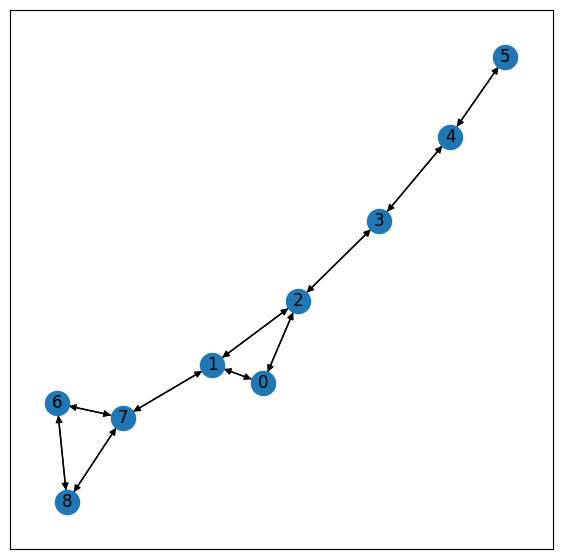

In [4]:
# Build a simple artificail graph of 3 balanced communities with DGL
r = torch.tensor([0,0,1,3,4,6,6,7,1,2]) # YOUR CODE HERE # what does r mean? row?
c = torch.tensor([2,1,2,4,5,7,8,8,7,3]) # YOUR CODE HERE # what does c mean? column?
n = 9
G_dgl = dgl.graph((r,c), num_nodes=n) # YOUR CODE HERE )
G_dgl = dgl.add_reverse_edges(G_dgl) # undirected graph
print(G_dgl)
print(G_dgl.nodes())
print(G_dgl.edges())

# Plot graph
G_nx = dgl.to_networkx(G_dgl)
plt.figure(figsize=[7,7])
nx.draw_networkx(G_nx, with_labels=True)


### Question 2: Partition the artificial graph using Metis

Metis is accessible through the PyMetis package:  
https://pypi.org/project/PyMetis

Experiment with different numbers of partitions to see how the graph is divided.


[1, 0, 1, 1, 1, 1, 0, 0, 0]
C_metis_pyg tensor([1, 0, 1, 1, 1, 1, 0, 0, 0])


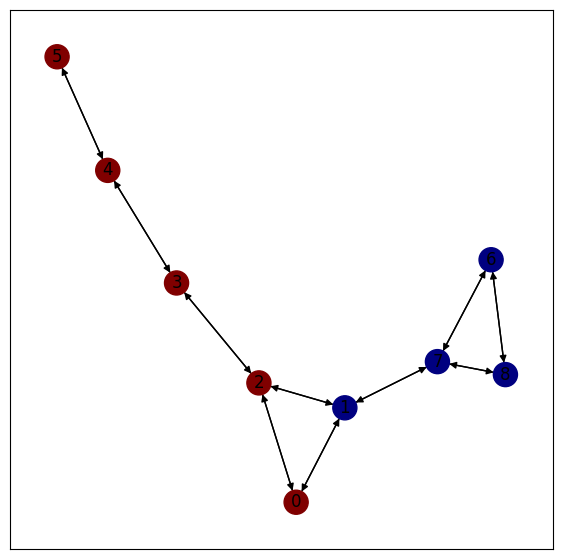

In [12]:
# Run Metis with PyMetis
num_parts = 2
G_nx = dgl.to_networkx(G_dgl)
_, part_vert = pymetis.part_graph(nparts=num_parts, adjacency=G_nx.adj) # YOUR CODE HERE 
print(part_vert)
C_metis_pyg = torch.tensor(part_vert).long()
print('C_metis_pyg',C_metis_pyg)
plt.figure(figsize=[7,7])
nx.draw_networkx(G_nx, with_labels=True, node_color=C_metis_pyg, cmap='jet')


Convert a graph into a bidirected graph: 0.002 seconds, peak memory: 0.000 GB
Construct multi-constraint weights: 0.004 seconds, peak memory: 0.000 GB
Metis partitioning: 0.001 seconds, peak memory: 0.000 GB
C_metis_dgl tensor([0, 0, 0, 1, 1, 1, 2, 2, 2])


[22:55:19] /tmp/dgl_src/src/graph/transform/metis_partition_hetero.cc:89: Partition a graph with 9 nodes and 20 edges into 3 parts and get 2 edge cuts


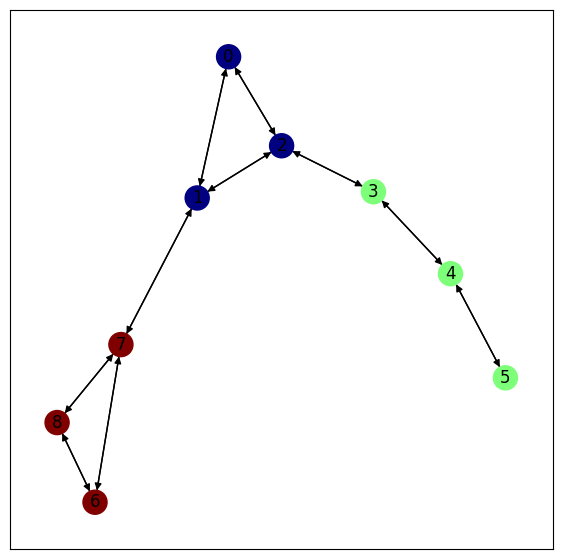

In [ ]:
# Run Metis with DGL
#  https://docs.dgl.ai/en/0.8.x/generated/dgl.dataloading.ClusterGCNSampler.html

if platform.system()!='Windows': # os is not Windows
    try: os.remove("cluster_gcn.pkl") # remove any existing partition
    except: pass 
    num_parts = 3
    sampler = dgl.dataloading.ClusterGCNSampler(G_dgl, num_parts) 
    C_metis_dgl = torch.zeros(G_dgl.num_nodes()).long() # zero tensor
    for idx, (idx_start, idx_end) in enumerate(zip(sampler.partition_offset[:num_parts], sampler.partition_offset[1:num_parts+1])):
        C_metis_dgl[sampler.partition_node_ids[idx_start: idx_end]] = idx
    print('C_metis_dgl',C_metis_dgl)
    G_nx = dgl.to_networkx(G_dgl)
    plt.figure(figsize=[7,7])
    nx.draw_networkx(G_nx, with_labels=True, node_color=C_metis_dgl, cmap='jet')
else:
    print('DGL has not yet implemented Metis under Windows.')
    

# Real-world USPS image graph

In [15]:
# Load USPS Music dataset
mat = scipy.io.loadmat('datasets/USPS.mat')
W = mat['W'] # scipy.sparse._csc.csc_matrix
n = W.shape[0]
Cgt = mat['Cgt']-1; Cgt = Cgt.squeeze()
nc = len(np.unique(Cgt))
print('n,nc:',n,nc) # number of nodes, number of communities


n,nc: 9298 10


### Question 3: Partition the real-world USPS image graph using Metis
https://datasets.activeloop.ai/docs/ml/datasets/usps-dataset

After partitioning the graph using Metis, visualize it with clusters represented by different colors.

Do the resulting clusters reveal any meaningful patterns?


In [19]:
# Run Metis with PyMetis
num_parts = nc
G_nx = nx.from_scipy_sparse_array(W)
start = time.time()
_, part_vert = pymetis.part_graph(nparts=num_parts, adjacency=G_nx) # YOUR CODE HERE 
print('Time(sec) : %.3f' % (time.time()-start) )
C_metis_pyg = np.array(part_vert,dtype='int32')
acc = compute_purity(C_metis_pyg, Cgt, nc)
print('\nAccuracy Metis PyG :',acc)


Time(sec) : 0.024

Accuracy Metis PyG : 81.79178317917832


In [18]:
# Run Metis with DGL
#  https://docs.dgl.ai/en/0.8.x/generated/dgl.dataloading.ClusterGCNSampler.html

try: os.remove("cluster_gcn.pkl") # remove any existing partition
except: pass 
num_parts = nc
G_dgl = dgl.from_scipy(W)
start = time.time()
sampler = dgl.dataloading.ClusterGCNSampler(G_dgl, num_parts) 
print('Time(sec) : %.3f' % (time.time()-start) )
C_metis_dgl = torch.zeros(G_dgl.num_nodes()).long()
for idx, (idx_start, idx_end) in enumerate(zip(sampler.partition_offset[:num_parts], sampler.partition_offset[1:num_parts+1])):
    C_metis_dgl[sampler.partition_node_ids[idx_start: idx_end]] = idx
print('C_metis_dgl',C_metis_dgl)
C_metis_dgl = np.array(C_metis_dgl, dtype='int32')
acc = compute_purity(C_metis_dgl, Cgt, nc)
print('\nAccuracy Metis DGL :',acc)


Convert a graph into a bidirected graph: 0.004 seconds, peak memory: 0.000 GB
Construct multi-constraint weights: 0.000 seconds, peak memory: 0.000 GB
Metis partitioning: 0.019 seconds, peak memory: 0.000 GB
Time(sec) : 0.025
C_metis_dgl tensor([1, 0, 0,  ..., 9, 9, 9])

Accuracy Metis DGL : 81.10346311034631


[22:57:23] /tmp/dgl_src/src/graph/transform/metis_partition_hetero.cc:89: Partition a graph with 9298 nodes and 146060 edges into 10 parts and get 6607 edge cuts


Time(sec): 8.217
(9298,)


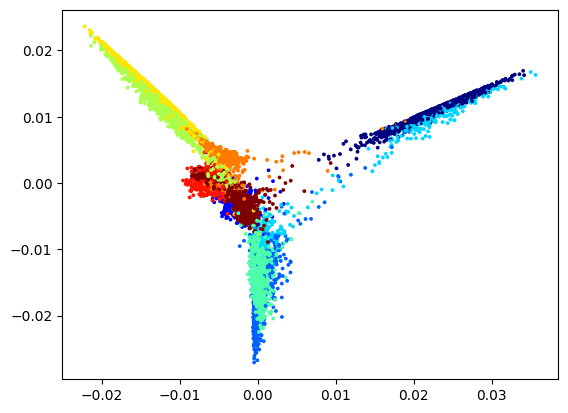

In [20]:
# Compute non-linear dim reduction
start = time.time()
[X,Y,Z] = nldr_visualization(nx.to_numpy_array(G_nx))
print('Time(sec): %.3f' % (time.time()-start) )
print(X.shape)

# 2D Visualization
plt.figure(3)
plt.scatter(X, Y, c=C_metis_pyg, s=3, color=pyplot.jet())
plt.show()


In [21]:
# 3D Visualization
import plotly.graph_objects as go
data = go.Scatter3d(x=X, y=Y, z=Z, mode='markers', marker=dict(size=1, color=C_metis_pyg, colorscale='jet', opacity=1)) # data as points
# data = go.Scatter3d(x=Xvis, y=Yvis, z=Zvis, mode='markers', marker=dict(size=1, color=C, colorscale='jet', opacity=1, showscale=True)) # w/ colobar 
fig = go.Figure(data=[data]) 
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30, pad=0)) # tight layout but t=25 required for showing title 
fig.update_layout(autosize=False, width=600, height=600, title_text="3D visualization of USPS image graph") # figure size and title
# fig.update_layout(scene = dict(xaxis = dict(visible=False), yaxis = dict(visible=False), zaxis = dict(visible=False))) # no grid, no axis 
# fig.update_layout(scene = dict(xaxis_title = ' ', yaxis_title = ' ', zaxis_title = ' ')) # no axis name 
fig.update_layout(scene = dict(zaxis = dict(showgrid = True, showticklabels = False), zaxis_title = ' ') ) # no range values, no axis name, grid on
fig.update_layout(scene = dict(yaxis = dict(showgrid = True, showticklabels = False), yaxis_title = ' ') ) # no range values, no axis name, grid on
fig.update_layout(scene = dict(xaxis = dict(showgrid = True, showticklabels = False), xaxis_title = ' ') ) # no range values, no axis name, grid on
fig.layout.scene.aspectratio = {'x':1, 'y':1, 'z':1}
fig.show()
